### Normalized vs Unnormalized plots

need to do all the datasets.

For ADNI, I am just going to combine all the domains together into one before and after.

generate plots detailing the intensity of FLAIR only in the brain matter, excluding voxels which have an intensity of 0 in the normalized plots.

For non ADNI data, also show the normalized and unnormalized intensities of the WMH class.

In [1]:
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

#### Chal data and CVD data post normalization
I should do as maria has done, kde along with bar plots.

In [7]:
import os
from trustworthai.utils.fitting_and_inference.get_scratch_dir import scratch_dir
from twaidata.torchdatasets.in_ram_ds import MRISegmentation3DDataset
root_dir = os.path.join(scratch_dir(), "preprep/out_data/collated/")
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

domains_ed = [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

domains_chal = [
    wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
]

In [44]:
ds = "ed"

In [45]:
if ds == "ed":
    domains = domains_ed
    domain_names = ["Domain A", "Domain B", "Domain C", "Domain D"]
elif ds == "chal":
    domains = domains_chal
    domain_names = ["Singapore", "Utrecht", "Amsterdam"]
else:
    raise ValueError(f"ds {ds} unknown, pick either ed | chal")

datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=None) for domain in domains]

In [46]:
datasets_domains[0][0][0].shape

torch.Size([3, 40, 224, 160])

In [47]:
# extract the flair voxels
def get_selected_voxels(datasets_domains):
    selected_voxels_per_domain = []
    for domain in range(len(datasets_domains)):
        selected_voxels = []
        for i in tqdm(range(len(datasets_domains[domain])), position=0, leave=True):
        # for i in tqdm(range(2), position=0, leave=True):
            scan_id = i
            example_flair = datasets_domains[domain][scan_id][0][0]
            example_mask = datasets_domains[domain][scan_id][0][1] == 1

            # non zero voxels
            voxels = example_flair[example_mask & (example_flair != 0)]

            selected_voxels.append(voxels)

        selected_voxels = torch.cat(selected_voxels)
        selected_voxels_per_domain.append(selected_voxels)
    # build the relevant dataframe
    df = pd.DataFrame({
        "voxel_intensity": torch.cat(selected_voxels_per_domain),
        "domain_id": torch.cat([torch.ones(len(selected_voxels_per_domain[i])) * i for i in range(len(datasets_domains))])
    })
    return df

In [48]:
df = get_selected_voxels(datasets_domains)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 124.54it/s]


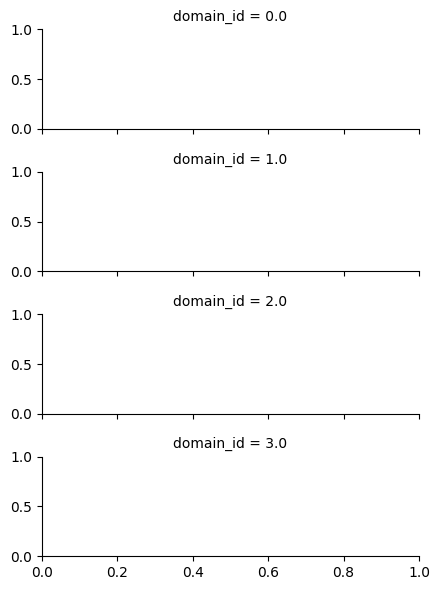

In [50]:
g = sns.FacetGrid(df, #the dataframe to pull from
                  row="domain_id", #define the column for each subplot row to be differentiated by
                  hue="domain_id", #define the column for each subplot color to be differentiated by
                  aspect=3, #aspect * height = width
                  height=1.5, #height of each subplot
                  palette=['#4285F4','#EA4335','#FBBC05','#34A853'] #google colors
                 )

In [51]:
g.map(sns.kdeplot, "voxel_intensity", fill=True, alpha=1, lw=1.5, bw_method=0.2) # shaded area
g.map(sns.kdeplot, "voxel_intensity", lw=4, bw_method=0.2) # borden with thick line

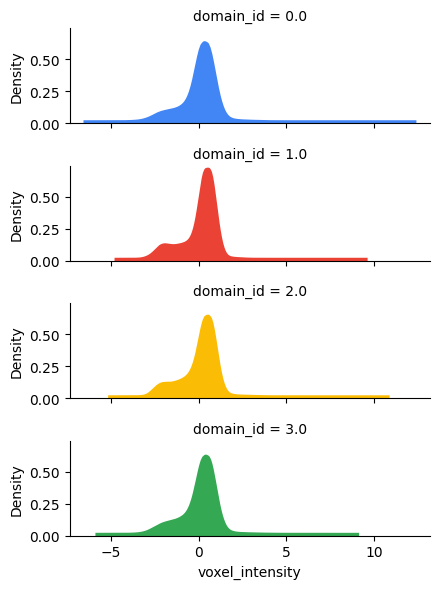

In [52]:
g.fig

In [53]:
g.set_titles("") #set title to blank
#g.set(yticks=[]) #set y ticks to blank
g.despine(left=True, bottom=True) # re3move spines
g.tick_params(left=False, bottom=False) # remove the little tick markers next to the numbers

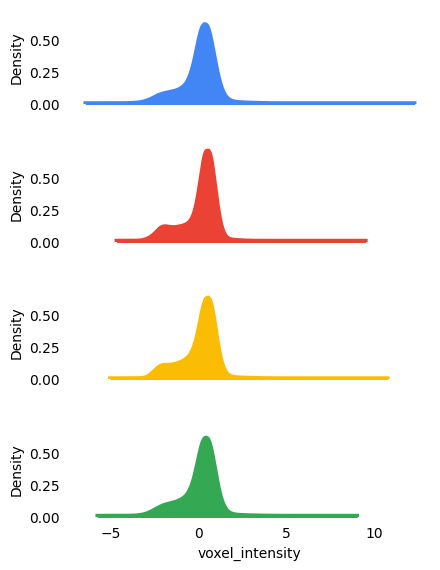

In [54]:
g.fig

In [55]:
# g.map(plt.axhline, y=-0.0001, lw=4)# adds coloured baseline (negative prevents artefact where they dont quite line up at the zero line....
# g.fig

In [56]:
def label(x, color, label):
    ax = plt.gca() #get the axes of the current object
    print(label)
    ax.text(0, .2, #location of text
            domain_names[int(float(label))], #text label
            fontweight="bold", color=color, size=10, #text attributes
            ha="left", va="center", #alignment specifications
            transform=ax.transAxes) #specify axes of transformation

g.map(label, "voxel_intensity") #the function counts as a plotting object!

0.0
1.0
2.0
3.0


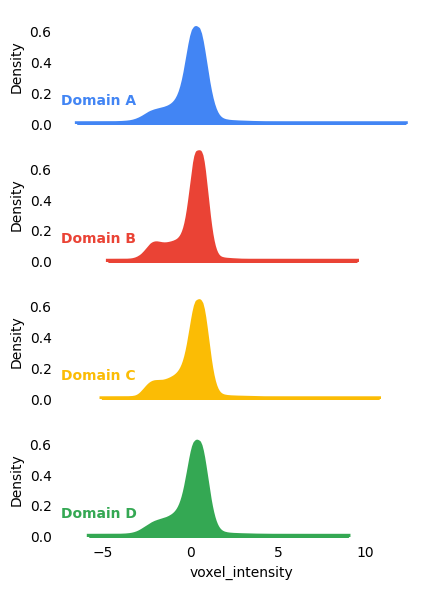

In [57]:
g.fig

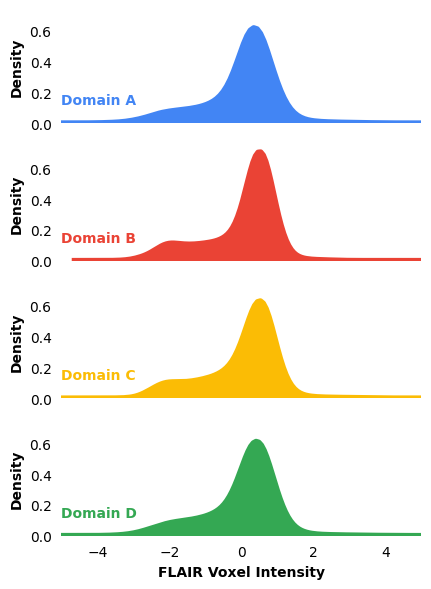

In [58]:
g.set(xlim=(-5, 5))
g.set_xlabels("FLAIR Voxel Intensity", fontweight="bold")
g.set_ylabels("Density", fontweight="bold")
g.fig

In [59]:
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

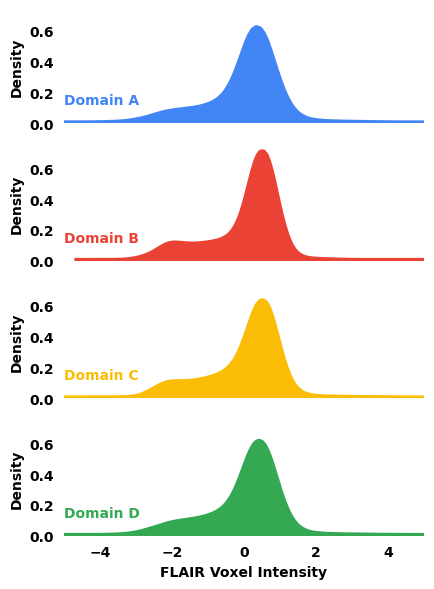

In [60]:
g.fig

In [61]:
g.savefig(f"{ds}_post_norm_domain_intensities.pdf")

#### Loading the unnormalized versions of the ed and challenge data

In [2]:
import os
import nibabel as nib


In [3]:
ds = "ed"

if ds == "ed":
    preproc_folder_path = "/home/s2208943/ipdis/data/preprocessed_data/EdData/"
    domains_storage_name = ["domainA", "domainB", "domainC", "domainD"] # the name of the domain in the filesystem
    domain_names = ["Domain A", "Domain B", "Domain C", "Domain D"]
    xlim = (-100, 750)
if ds == "chal":
    preproc_folder_path = "/home/s2208943/ipdis/data/preprocessed_data/WMH_challenge_dataset/"
    domains_storage_name = ["Singapore", "Utrecht", "GE3T"]
    domain_names = ["Singapore", "Utrecht", "Amsterdam"]
    xlim = (-100, 1250)

In [4]:
def get_selected_voxels_unnormalized(domains_storage_name):
    selected_voxels_per_domain = []
    for domain in domains_storage_name:
        selected_voxels = []
        folder = f"{preproc_folder_path}{domain}/imgs/"
        print(folder)
        flairs = [f"{folder}{f}" for f in os.listdir(folder) if "_FLAIR_BET.nii.gz" in f]
        selected_voxels = []
        for flair in tqdm(flairs, position=0, leave=True):
        # for flair in [flairs[0]]:
            data = nib.load(flair).get_fdata()
            data = data[data!=0]
            selected_voxels.append(torch.from_numpy(data))

        selected_voxels = torch.cat(selected_voxels)
        selected_voxels_per_domain.append(selected_voxels)
        # build the relevant dataframe
    df = pd.DataFrame({
        "voxel_intensity": torch.cat(selected_voxels_per_domain),
        "domain_id": torch.cat([torch.ones(len(selected_voxels_per_domain[i])) * i for i in range(len(domains_storage_name))])
    })
    return df

In [5]:
df = get_selected_voxels_unnormalized(domains_storage_name)

/home/s2208943/ipdis/data/preprocessed_data/EdData/domainA/imgs/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.63it/s]


/home/s2208943/ipdis/data/preprocessed_data/EdData/domainB/imgs/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.18it/s]


/home/s2208943/ipdis/data/preprocessed_data/EdData/domainC/imgs/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.78it/s]


/home/s2208943/ipdis/data/preprocessed_data/EdData/domainD/imgs/


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:24<00:00,  4.56it/s]


In [6]:
df

,voxel_intensity,domain_id
0,26.998215,0.0
1,41.000870,0.0
2,23.002060,0.0
3,22.003021,0.0
4,38.003754,0.0
...,...,...
154863669,235.999399,3.0
154863670,128.997182,3.0
154863671,130.994588,3.0
154863672,228.996728,3.0


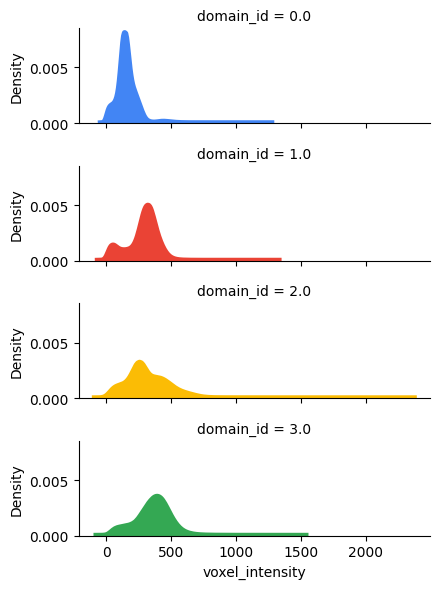

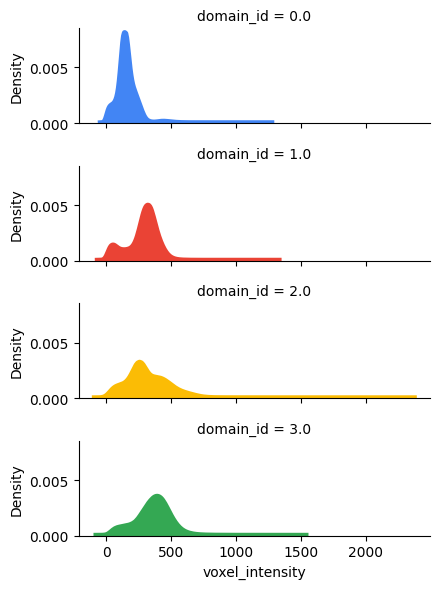

In [7]:
g = sns.FacetGrid(df, #the dataframe to pull from
                  row="domain_id", #define the column for each subplot row to be differentiated by
                  hue="domain_id", #define the column for each subplot color to be differentiated by
                  aspect=3, #aspect * height = width
                  height=1.5, #height of each subplot
                  palette=['#4285F4','#EA4335','#FBBC05','#34A853'] #google colors
                 )

g.map(sns.kdeplot, "voxel_intensity", fill=True, alpha=1, lw=1.5, bw_method=0.2) # shaded area
g.map(sns.kdeplot, "voxel_intensity", lw=4, bw_method=0.2) # borden with thick line

g.fig

In [8]:
g.set_titles("") #set title to blank
#g.set(yticks=[]) #set y ticks to blank
g.despine(left=True, bottom=True) # re3move spines
g.tick_params(left=False, bottom=False) # remove the little tick markers next to the numbers

def label(x, color, label):
    ax = plt.gca() #get the axes of the current object
    print(label)
    ax.text(0.7, 0.9, #location of text
            domain_names[int(float(label))], #text label
            fontweight="bold", color=color, size=10, #text attributes
            ha="left", va="center", #alignment specifications
            transform=ax.transAxes) #specify axes of transformation

g.map(label, "voxel_intensity") #the function counts as a plotting object!

g.set_xlabels("FLAIR Voxel Intensity", fontweight="bold")
g.set_ylabels("Density", fontweight="bold")

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

0.0
1.0
2.0
3.0


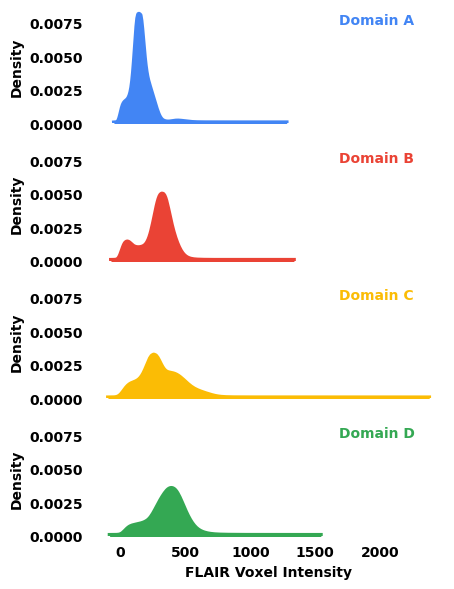

In [9]:
g.fig

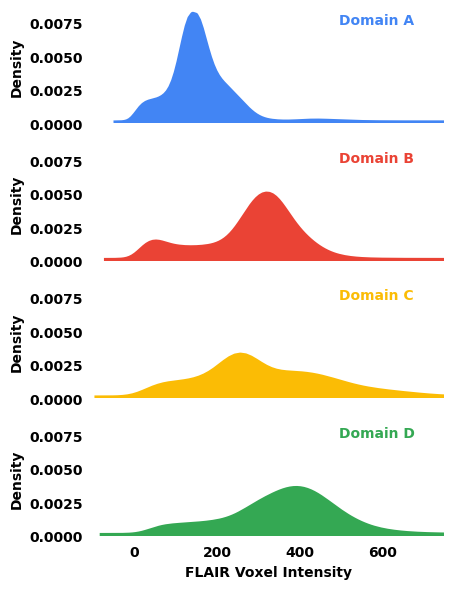

In [10]:
g.set(xlim=xlim)
g.fig

In [11]:
g.savefig(f"{ds}_pre_norm_domain_intensities.pdf")